In [6]:
# import packages
import json
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os 
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics
import numpy as np # linear algebra
import pandas as pd

In [7]:
json_1 = '/content/drive/MyDrive/datasets/CB_dataset/train.csv'
# json_2 = '../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json'


Load data into `Pandas.DataFrame`

In [8]:
toxic_data = pd.read_csv(json_1)
toxic_data.drop(['id'], axis=1, inplace=True)
toxic_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [9]:
X = toxic_data["comment_text"]
Y = toxic_data[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [10]:

# encode class values as integers
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(Y)

In [11]:
dummy_y[6]

# it is basically like shru k 3, 1 hain to 1 index par 1 hua va sb k aagy, 4th 0 hai to 0th index 1 hua va, 1 mean on and 0 mean off. 

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

Now check the distribution (ratio) of our target `is_sarcastic`.

In [ ]:
# df.is_sarcastic.value_counts(normalize=True), df.is_sarcastic.value_counts()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


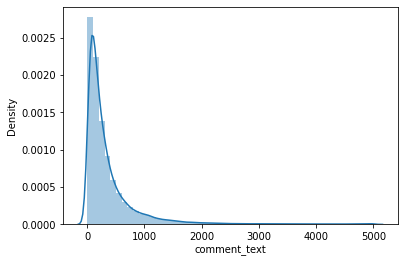

In [12]:
# A birdview of headline length. Seems the majority has a length of 70, that's about 5 to 15 words, which makes sence.
sbs.distplot(toxic_data.comment_text.str.len())


The data is well-balanced, which is rare in reality but great for our practicing purpose.

Now we will try Naive Bayes as our base model.

## Building Base Model: Naive Bayes
First step, we should tokenize texts into vectors.

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


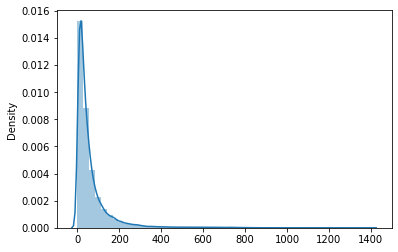

In [13]:
vocab_size = 10000 # max_features 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
train_inputs = tokenizer.texts_to_sequences(X)
sbs.distplot([len(l) for l in train_inputs])

See, the above graph confirms our guess: most headline has 5 - 15 words. 


In [ ]:
train_inputs = tf.keras.preprocessing.sequence.pad_sequences(train_inputs, padding='post', maxlen=50)
train_labels = dummy_y

# Split data into train /validation 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(train_inputs, train_labels, test_size=0.2, random_state=0)
train_inputs[0]

array([ 688,   75,    1,  126,  130,  177,   29,  672, 4511, 1116,   86,
        331,   51, 2278,   50, 6864,   15,   60, 2756,  148,    7, 2937,
         34,  117, 1221, 2825,    4,   45,   59,  244,    1,  365,   31,
          1,   38,   27,  143,   73, 3462,   89, 3085, 4583, 2273,  985,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
X_train.shape

(127656, 50)

Validate how the model performs. 

Turs out that the `accuracy_score` is only 0.58, which is merely a little better than random guess.
But at least wew know what to expect now. We're going to try more powerful models, e.g., CNN, to see whether we can reach a `accuracy_score = 0.7` or higher.

In [ ]:
y_preds = nb.predict(X_val)
print(f"Accuracy score", sklearn.metrics.accuracy_score(y_val, y_preds))
print(f"Classification report\n", sklearn.metrics.classification_report(y_val, y_preds))

Accuracy score 0.5718831898165481
Classification report
               precision    recall  f1-score   support

           0       0.60      0.69      0.64      3007
           1       0.51      0.42      0.46      2335

    accuracy                           0.57      5342
   macro avg       0.56      0.55      0.55      5342
weighted avg       0.56      0.57      0.56      5342



# Another model: Keras LSTM

In [ ]:
max_len = 50
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 128)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embed_text)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 20, 128)           1280000   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 64)            41216     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080  

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

Train on 19230 samples, validate on 2137 samples
Epoch 1/30
19200/19230 [============================>.] - ETA: 0s - loss: 0.5742 - accuracy: 0.6864
Epoch 00001: val_accuracy improved from -inf to 0.85400, saving model to model_best.hdf5
19230/19230 [==============================] - 8s 419us/sample - loss: 0.5738 - accuracy: 0.6866 - val_loss: 0.3461 - val_accuracy: 0.8540
Epoch 2/30
18688/19230 [============================>.] - ETA: 0s - loss: 0.2827 - accuracy: 0.8939
Epoch 00002: val_accuracy improved from 0.85400 to 0.86055, saving model to model_best.hdf5
19230/19230 [==============================] - 2s 85us/sample - loss: 0.2826 - accuracy: 0.8940 - val_loss: 0.3323 - val_accuracy: 0.8606
Epoch 3/30
18688/19230 [============================>.] - ETA: 0s - loss: 0.1828 - accuracy: 0.9386
Epoch 00003: val_accuracy improved from 0.86055 to 0.86196, saving model to model_best.hdf5
19230/19230 [==============================] - 2s 97us/sample - loss: 0.1835 - accuracy: 0.9384 - val

In [ ]:
model = tf.keras.models.load_model('model_best.hdf5')
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds))

Test accracy score 0.8554848371396481


Now we can see, the result is better. The validation accuracy has improved from `0.58` to `0.8521`, which is not ideal, but good enough to detect sarcasm by reading a headline of an article.

A close view will also finds out that this model is apparrenly overfitting our dataset. We will also do experiments on word embedding and BERT later to seen any improvement of our model. 

# WordVector Embedding + LSTM

We now use pretrained wordvector https://code.google.com/archive/p/word2vec/ of Google News (after all, we're dealing with article headlines). 

The vectors trained on a part of the Google News dataset (about 100 billion words). The model contains 300-dimensional vectors for 3 million words and phrases. The phrases were obtained using a simple data-driven approach described in 'Distributed Representations of Words and Phrases and their Compositionality' (https://code.google.com/archive/p/word2vec/).

In [ ]:
%%time
import gensim.downloader as api

def embed_word_vector(word_index, pretrained='word2vec-google-news-300'):
    embed_size = 300 # Google news vector is 300-dimensional
    vector = api.load(pretrained)
    zeros = [0] * embed_size
    matrix = np.zeros((vocab_size, embed_size)) 
    
    for word, i in word_index.items():
        if i >= vocab_size or word not in vector: continue 
        matrix[i] = vector[word]
    
    print("Embed word vector completed.")
    return matrix

CPU times: user 73.7 ms, sys: 14 ms, total: 87.7 ms
Wall time: 215 ms


Update embedding layer weights of our model

In [ ]:
%%time
pretrained = 'glove-wiki-gigaword-300'
matrix = embed_word_vector(tokenizer.word_index, pretrained=pretrained)

NameError: ignored

In [ ]:
max_len = 20
text_input = tf.keras.Input(shape=(max_len, ))
embed_text = tf.keras.layers.Embedding(vocab_size, 300, weights=[matrix], trainable=False)(text_input)

net = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embed_text)
net = tf.keras.layers.GlobalMaxPool1D()(net)
net = tf.keras.layers.Dense(64, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
net = tf.keras.layers.Dense(32, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)

output = tf.keras.layers.Dense(1, activation='sigmoid')(net)
model = tf.keras.models.Model(text_input, output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 20, 300)           3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 256)           330240    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080

Re run our model to see if any improvements we got.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

mc = tf.keras.callbacks.ModelCheckpoint('model_best_embed.hdf5', monitor='val_accuracy', 
                                        verbose=1, save_best_only=True, mode='max')
es = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", mode="max", patience=5)
    
history = model.fit(X_train, y_train,
                    epochs=30, batch_size=256, callbacks=[mc, es], 
                    validation_split=0.1, verbose=1)

Train on 19230 samples, validate on 2137 samples
Epoch 1/30
18688/19230 [============================>.] - ETA: 0s - loss: 0.5886 - accuracy: 0.6775
Epoch 00001: val_accuracy improved from -inf to 0.79364, saving model to model_best_embed.hdf5
19230/19230 [==============================] - 4s 203us/sample - loss: 0.5869 - accuracy: 0.6798 - val_loss: 0.4357 - val_accuracy: 0.7936
Epoch 2/30
17920/19230 [==========================>...] - ETA: 0s - loss: 0.4074 - accuracy: 0.8244
Epoch 00002: val_accuracy improved from 0.79364 to 0.83060, saving model to model_best_embed.hdf5
19230/19230 [==============================] - 1s 43us/sample - loss: 0.4078 - accuracy: 0.8245 - val_loss: 0.3755 - val_accuracy: 0.8306
Epoch 3/30
18176/19230 [===========================>..] - ETA: 0s - loss: 0.3285 - accuracy: 0.8683
Epoch 00003: val_accuracy improved from 0.83060 to 0.84558, saving model to model_best_embed.hdf5
19230/19230 [==============================] - 1s 45us/sample - loss: 0.3284 - accu

From the training history, we can see performance of this model is pretty similiar to our previous one. Thus, we know pretrained NLP models are not going help us much. We have to find other ways to improve the score.

In [ ]:
model = tf.keras.models.load_model('model_best_embed.hdf5')
y_preds = model.predict(X_val, batch_size=1024).round().astype(int)
print("Test accracy score", sklearn.metrics.accuracy_score(y_val, y_preds))

Test accracy score 0.8627854736053913


# BERT, NLP text classification killer

In [ ]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [ ]:
%%time
import tensorflow_hub as hub 
import tokenization

module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 8.92 s, sys: 1.36 s, total: 10.3 s
Wall time: 11.2 s


In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)


In [ ]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Remember in previous sections, we have explored on the headline length. Most of them has a length between 50 to 150, and the majority has a length of 70. We set the length to 120.

In [ ]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(df.headline, df['is_sarcastic'], 
                                                                          test_size=0.1, random_state=0)
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

Let's build the model and train on it.

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [ ]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

train_history = model.fit(
    X_train, y_train, 
    validation_split=0.1,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=16,
    verbose=1
)

Train on 21634 samples, validate on 2404 samples
Epoch 1/3
21632/21634 [============================>.] - ETA: 0s - loss: 0.3036 - accuracy: 0.8695
Epoch 00001: val_accuracy improved from -inf to 0.91597, saving model to model.h5
21634/21634 [==============================] - 304s 14ms/sample - loss: 0.3036 - accuracy: 0.8696 - val_loss: 0.2100 - val_accuracy: 0.9160
Epoch 2/3
21632/21634 [============================>.] - ETA: 0s - loss: 0.1521 - accuracy: 0.9443
Epoch 00002: val_accuracy improved from 0.91597 to 0.92554, saving model to model.h5
21634/21634 [==============================] - 288s 13ms/sample - loss: 0.1520 - accuracy: 0.9443 - val_loss: 0.2174 - val_accuracy: 0.9255
Epoch 3/3
21632/21634 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9714
Epoch 00003: val_accuracy did not improve from 0.92554
21634/21634 [==============================] - 285s 13ms/sample - loss: 0.0843 - accuracy: 0.9714 - val_loss: 0.2542 - val_accuracy: 0.9193
CPU times: u

In [ ]:
%%time
model.load_weights('model.h5')
y_preds = model.predict(X_val).round().astype(int)
print("Validation accuracy: ", sklearn.metrics.accuracy_score(y_val, y_preds))

Validation accuracy:  0.9284912017970798
CPU times: user 7.51 s, sys: 3.76 s, total: 11.3 s
Wall time: 11.3 s


* The validation accuracy is `92%`, impressive !

The result can be further improved by: 
1. increasing the length of `max_len`, i.e., the length of input headline length 
2. fine-tuning parameters 
3. trying other pretrained bert modules.

To summarize, BERT is definitely the winner of text classification tasks.

# **My Own code from here**

In [ ]:
import tensorflow as tf

from numpy import array
from keras.preprocessing.text import one_hot
# from keras.preprocessing.sequence import pad_sequences
# from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
# from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
# from keras.preprocessing.text import Tokenizer
# from keras.layers import Input
# from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

# tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)

In [ ]:
toxic_comments = pd.read_csv("/content/drive/MyDrive/datasets/CB_dataset/train.csv")

In [ ]:
print(toxic_comments.shape)

toxic_comments.head()

(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [ ]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_one_hot = mlb.fit_transform(toxic_comments_labels.values)

In [ ]:
y_one_hot.shape

(159571, 2)

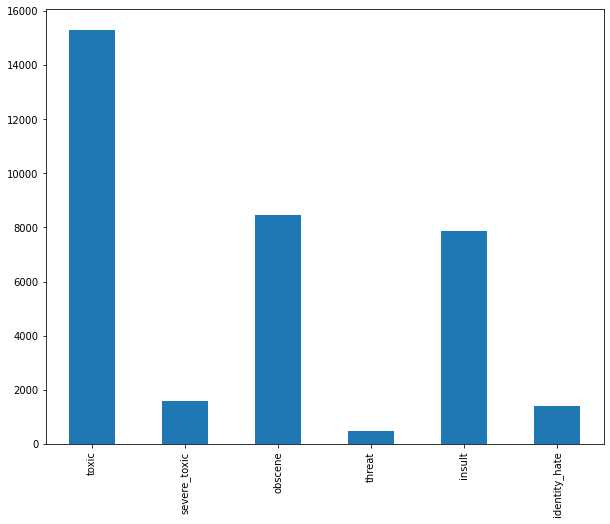

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [ ]:
# You can see that the "toxic" comment has the highest frequency of occurrence followed by "obscene" and "insult", respectively.

**Creating Multi-label Text Classification Models**

In [ ]:
# Multi-lable Text Classification Model with Single Output Layer

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [ ]:
# Here we do not need to perform any one-hot encoding because our output labels are already in the form of one-hot encoded vectors.
# In the next step, we will divide our data into training and test sets:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# We need to convert text inputs into embedded vectors.

In [ ]:
vocab_size = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
# We will be using GloVe word embeddings to convert text inputs to their numeric counterparts.

In [ ]:
# %%time
# import gensim.downloader as api

# def embed_word_vector(word_index, pretrained='word2vec-google-news-300'):
#     embed_size = 300 # Google news vector is 300-dimensional
#     vector = api.load(pretrained)
#     zeros = [0] * embed_size
#     matrix = np.zeros((vocab_size, embed_size)) 
    
#     for word, i in word_index.items():
#         if i >= vocab_size or word not in vector: continue 
#         matrix[i] = vector[word]
    
#     print("Embed word vector completed.")
#     return matrix

In [ ]:
# %%time
# pretrained = 'glove-wiki-gigaword-300'
# matrix = embed_word_vector(tokenizer.word_index, pretrained=pretrained)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/datasets/CB_dataset/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
# The following script creates the model. Our model will have one input layer, one embedding layer, one LSTM layer with
#  128 neurons and one output layer with 6 neurons since we have 6 labels in the output.

In [ ]:
deep_inputs = tf.keras.Input(shape=(maxlen, ))
embedding_layer = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embedding_layer)
net = tf.keras.layers.GlobalMaxPool1D()(LSTM_Layer_1)
net = tf.keras.layers.Dense(124, activation='relu')(net)
net = tf.keras.layers.Dropout(0.4)(net)
output = tf.keras.layers.Dense(6, activation='sigmoid')(net)
model = tf.keras.models.Model(inputs=deep_inputs, outputs=output)
model.summary()

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 200, 100)          14824300  
                                                                 
 bidirectional_7 (Bidirectio  (None, 200, 256)         176640    
 nal)                                                            
                                                                 
 global_max_pooling1d_7 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 124)               31868     
                                                                 
 dropout_7 (Dropout)         (None, 124)               0   

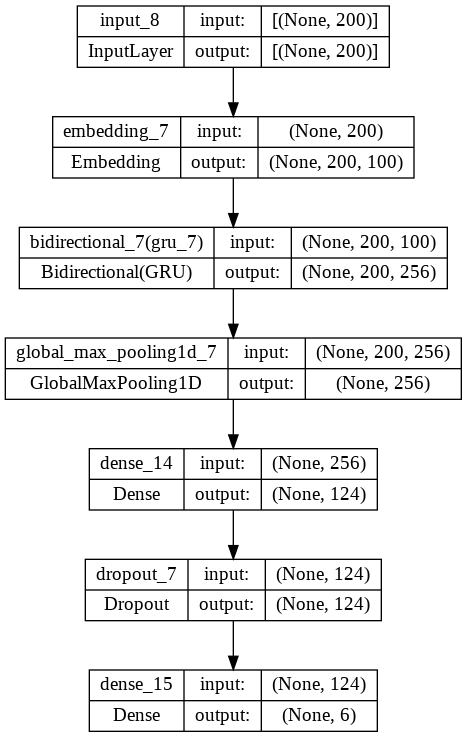

In [ ]:
# The following script prints the architecture of our neural network:

from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [ ]:
# From the figure above, you can see that the output layer only contains 1 dense layer with 6 neurons. Let's now train our model:

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
798/798 [==============================] - 49s 54ms/step - loss: 0.3911 - acc: 0.9929 - val_loss: 0.3954 - val_acc: 0.9943
Epoch 2/5
798/798 [==============================] - 24s 31ms/step - loss: 0.3894 - acc: 0.9941 - val_loss: 0.3938 - val_acc: 0.9943
Epoch 3/5
798/798 [==============================] - 24s 30ms/step - loss: 0.3881 - acc: 0.9941 - val_loss: 0.3927 - val_acc: 0.9943
Epoch 4/5
798/798 [==============================] - 26s 33ms/step - loss: 0.3870 - acc: 0.9941 - val_loss: 0.3917 - val_acc: 0.9943
Epoch 5/5
798/798 [==============================] - 25s 32ms/step - loss: 0.3860 - acc: 0.9941 - val_loss: 0.3909 - val_acc: 0.9943


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 10s 10ms/step - loss: 0.3907 - acc: 0.9941
Test Score: 0.390667587518692
Test Accuracy: 0.9941093325614929


In [ ]:
y_pred = model.predict(X_test)


998/998 [==============================] - 11s 10ms/step


In [ ]:
from sklearn.metrics import label_ranking_average_precision_score

lrap = label_ranking_average_precision_score(y_test[0], y_pred[0])

ValueError: ignored

In [ ]:
X = tokenizer.texts_to_sequences(['You are a fucking stupid head and I a tired of your shit'])
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=maxlen)
#you must reoder the labls in alphabetical order (keras)
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
pred = model.predict(X)
for i, p in enumerate(pred[0]):
  print(labels[i], p)

1/1 [==============================] - 0s 64ms/step
toxic 0.020367365
severe_toxic 0.018566864
obscene 0.019043945
threat 0.018508988
insult 0.01898131
identity_hate 0.018555567


In [ ]:
pred
from sklearn.metrics import label_ranking_average_precision_score

lrap = label_ranking_average_precision_score(dd, pred)

In [ ]:
lrap

1.0

In [ ]:
toxic_comments_labels.values[6]
dd = np.expand_dims(y_test[6], 0)
dd.shape

(1, 6)

In [ ]:
# from sklearn.metrics import label_ranking_average_precision_score
# from sklearn.metrics import label_ranking_loss
# ranking_loss = label_ranking_loss(y_test, y_pred[0])

# ranking_scores = label_ranking_average_precision_score(y_one_hot[0], pred)

ValueError: ignored

In [ ]:
y_rank = []
for label_set in y_test:
    ranking = [i for i, label in enumerate(label_set) if label == 1]
    y_rank.append(ranking)

In [ ]:
import tensorflow.keras as keras
lrap = keras.metrics.LabelRankingAveragePrecision()(y_test, pred)
lrap

AttributeError: ignored

In [ ]:
ranking_loss

0.0054460633279370535

In [ ]:
from sklearn.preprocessing import label_binarize
y_binarized = label_binarize(y_test, classes=[0, 1, 2, 3,4,5])

In [ ]:
y_one_hot[1]

array([1, 0])

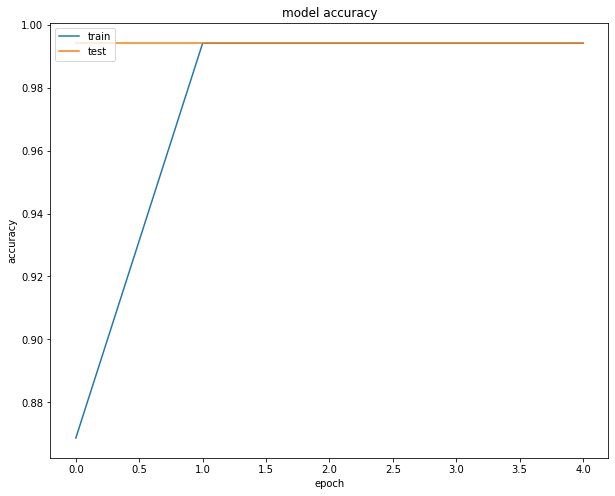

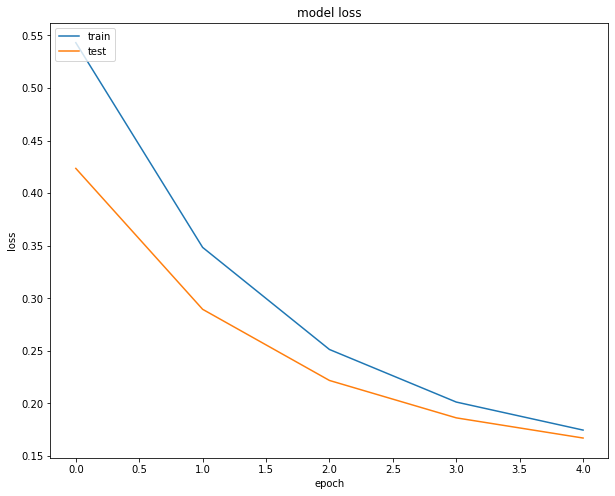

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# **Multi-lable Text Classification Model with Multiple Output Layers**

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

In [ ]:
vocab_size = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/MyDrive/datasets/CB_dataset/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
input_1 = tf.keras.Input(shape=(maxlen, ))
embedding_layer = tf.keras.layers.Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
net = tf.keras.layers.LSTM(128)(embedding_layer)
# LSTM_Layer_1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embedding_layer)
# net = tf.keras.layers.GlobalMaxPool1D()(LSTM_Layer_1)
# net = tf.keras.layers.Dense(124, activation='relu')(net)
# net = tf.keras.layers.Dropout(0.4)(net)
# output = tf.keras.layers.Dense(6, activation='sigmoid')(net)

output1 = Dense(1, activation='sigmoid')(net)
output2 = Dense(1, activation='sigmoid')(net)
output3 = Dense(1, activation='sigmoid')(net)
output4 = Dense(1, activation='sigmoid')(net)
output5 = Dense(1, activation='sigmoid')(net)
output6 = Dense(1, activation='sigmoid')(net)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 100)     14824300    ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 128)          117248      ['embedding[0][0]']              
                                                                                                  
 dense (Dense)                  (None, 1)            129         ['lstm[0][0]']                   
                                                                                              

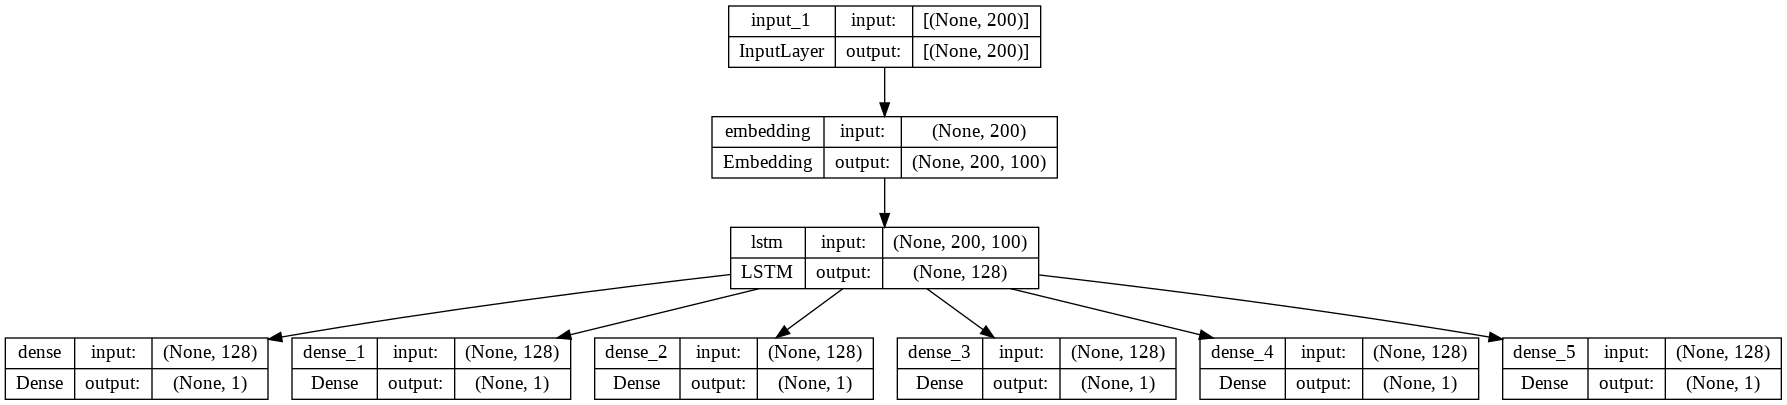

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
13/13 [==============================] - 12s 495ms/step - loss: 3.1738 - dense_loss: 0.5683 - dense_1_loss: 0.5170 - dense_2_loss: 0.5517 - dense_3_loss: 0.4805 - dense_4_loss: 0.5480 - dense_5_loss: 0.5082 - dense_acc: 0.9043 - dense_1_acc: 0.9900 - dense_2_acc: 0.9474 - dense_3_acc: 0.9969 - dense_4_acc: 0.9510 - dense_5_acc: 0.9916 - val_loss: 0.9301 - val_dense_loss: 0.3281 - val_dense_1_loss: 0.0885 - val_dense_2_loss: 0.2118 - val_dense_3_loss: 0.0271 - val_dense_4_loss: 0.1964 - val_dense_5_loss: 0.0781 - val_dense_acc: 0.9036 - val_dense_1_acc: 0.9901 - val_dense_2_acc: 0.9468 - val_dense_3_acc: 0.9967 - val_dense_4_acc: 0.9509 - val_dense_5_acc: 0.9902
Epoch 2/5
13/13 [==============================] - 6s 436ms/step - loss: 0.8780 - dense_loss: 0.3235 - dense_1_loss: 0.0635 - dense_2_loss: 0.2102 - dense_3_loss: 0.0218 - dense_4_loss: 0.2047 - dense_5_loss: 0.0542 - dense_acc: 0.9043 - dense_1_acc: 0.9900 - dense_2_acc: 0.9474 - dense_3_acc: 0.9969 - dense_4_acc: 0.9

In [ ]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 10s 10ms/step - loss: 0.8505 - dense_loss: 0.3157 - dense_1_loss: 0.0563 - dense_2_loss: 0.2094 - dense_3_loss: 0.0164 - dense_4_loss: 0.2002 - dense_5_loss: 0.0524 - dense_acc: 0.9042 - dense_1_acc: 0.9899 - dense_2_acc: 0.9463 - dense_3_acc: 0.9977 - dense_4_acc: 0.9494 - dense_5_acc: 0.9908
Test Score: 0.8504884243011475
Test Accuracy: 0.3156925141811371


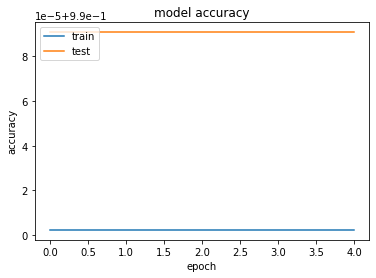

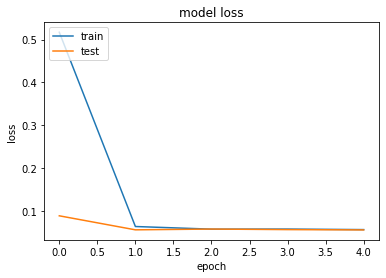

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()